## Causal Impact on Samsung Electronics Share Price

Samsung Electronics' formal president, Gunhee Lee, passed away on last 25 October 2020. It was forecasted by experts that his death would cause a significant change in the company's stock price. In order to find out whether there was any impact of the event, we are going to use Bayesian Structured Time Series method (BSTS) below.

### Contents
1. Introduction
2. Causal Impact Analysis
 - Step 1. Local Trend
 - Step 2. Seasonality
 - Step 3. Regression
3. Conclusion & Reference

### 1. Introduction

#### What is Bayesian Structured Time Series?
Google’s Causal Impact library provides a very straightforward implementation of a Structural Time-Series model that estimates the effect of a ‘designed’ intervention on a target time-series. This effect is measured by analysing the differences between the expected and the observed behaviour — specifically, the model generates a forecast counterfactual i.e. the expected observations of how the dependent variable might have evolved after the event had the event not occurred.

The method is different from A/B testing, in terms that the data is mainly gathered by natural observation, rather than by experiments between the certain timeframe. (e.g. how shipping fee increase has changed total payment amount, how competitor's marketing strategy changes have impacted our sales..) Since its wide range of usage in measuring the effect of events/campaigns retrospectively, it is actively being used in marketing analytics field.


#### How does the method works?

Below is the equation of the basic BSTS;

    Yt=μt+xtβ+St+et,et∼N(0,σ2e)
    μt+1=μt+νt,νt∼N(0,σ2ν)

Here ```xt``` denotes a set of regressors, ```St``` represents seasonality, and ```μt``` is the local level term. The local level term defines how the latent state evolves over time and is often referred to as the unobserved trend. This could, for example, represent an underlying growth in the brand value of a company or external factors that are hard to pinpoint, but it can also soak up short term fluctuations that should be controlled for with explicit terms. Note that the regressor coefficients, seasonality and trend are estimated simultaneously, which helps avoid strange coefficient estimates due to spurious relationships. ```xtβ```, a linear regression of covariates, help to explain our data further. This dataset does not have any regressors yet, so we’ll add covariates later in order to fit the Bayesian structural model.

In [344]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from causalimpact import CausalImpact
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [358]:
training_start = '2016-1-04'
training_end = '2020-10-23'
treatment_start = '2020-10-26'
treatment_end = '2021-1-22'
end_date = "2021-1-23"

y = ['005930.KS']
df_samsung = yf.download(y, start = training_start, threads = False, end = end_date, interval = '1d')
df_samsung = df_samsung/1100 # converting currency from KRW to USD

df_samsung = df_samsung['Adj Close'].rename('Samsung')
df_samsung

[*********************100%***********************]  1 of 1 completed


Date
2016-01-04    18.966055
2016-01-05    19.013271
2016-01-06    18.493869
2016-01-07    18.304996
2016-01-08    18.430913
                ...    
2021-01-18    76.930866
2021-01-19    78.741009
2021-01-20    78.922024
2021-01-21    79.736584
2021-01-22    78.559993
Name: Samsung, Length: 1235, dtype: float64

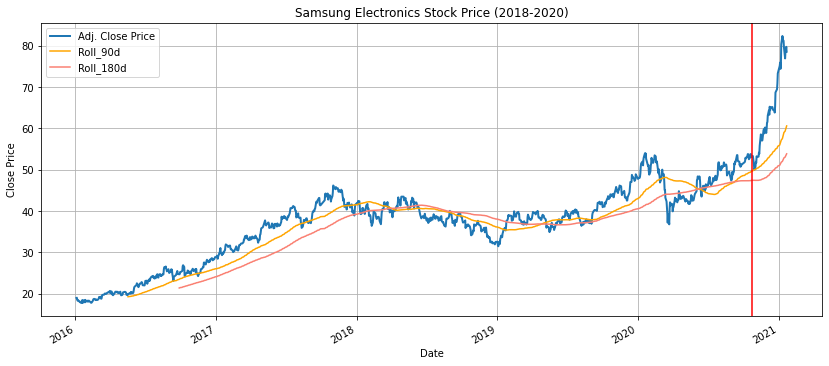

In [359]:
df_samsung.plot(lw=2., figsize=(14,6), label='Adj. Close Price')
df_samsung.rolling(90).mean().plot(lw=1.5, label='Roll_90d',c='orange')
df_samsung.rolling(180).mean().plot(lw=1.5, label='Roll_180d', c='salmon')
plt.title('Samsung Electronics Stock Price (2018-2020)')
plt.ylabel('Close Price')
plt.axvline(x = 18559, color = 'r')
plt.grid()
plt.legend(); 

Observations: 
- Even though the price headed downward along the year of 2019, there was increasing trend over the past 5 years overall.
- The slope of increase got steeper since the beginning of 2021, while the rise was rather slower until then.

### 2. Causal Impact Analysis
Now that we roughly know that the stock price has been significantly increasing since 2021, we would like to understand whether or not Mr.Lee's death would be responsible for this change. Let's find out how much the event account for the stock price rise. 

#### Step 1. Adding Local Level Only
We are going by running the model when only local trend is considered in the computation process. This includes short term fluctuation as well as long term trend since 2016. The counterfactual outcome is predicted based on random walk model.

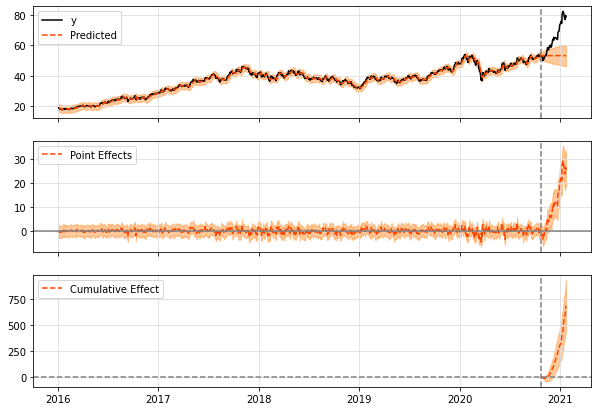

In [360]:
pre_period = [training_start, training_end] 
post_period = [treatment_start, treatment_end] 
impact = CausalImpact(df_samsung, pre_period = pre_period, post_period = post_period)
impact.plot()

- The observed ‘post-event’ time series and fitted model’s forecast counterfactual
- The pointwise causal effect, as estimated by the model. This is the difference between the observed outcome and the counterfactual outcome.
- The cumulative effect is the total amount of difference accumulated until certain point of time.

In [362]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    64.25              3983.8
Prediction (s.d.)         53.25 (2.09)       3301.2 (129.31)
95% CI                    [49.17, 57.34]     [3048.49, 3555.38]

Absolute effect (s.d.)    11.01 (2.09)       682.59 (129.31)
95% CI                    [6.91, 15.09]      [428.42, 935.3]

Relative effect (s.d.)    20.68% (3.92%)     20.68% (3.92%)
95% CI                    [12.98%, 28.33%]   [12.98%, 28.33%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


- Before you read a summary, make sure to focus on Average column instead of Cumulative. We are more interested in average change of stock price than the cumulative difference of stock price change.
- Our model has concluded that Mr.Lee's death has undoubtedly raised stock price by KRW 12,110 (20.68%), with statistical significance of 0. 
- Do note that this result is not reliable enough, since seasonal effect and covariate effect are not reflected.

#### Step 2. Adding Seasonal Impact
We have learn that the event is definitely responsible for the price change, but this is not delicate enough. There are far more variables that we can add to improve our model, and seasonality is one of them. Once we learn any seasonality lying in the business, we are going to add a seasonality parameter to see how absolute/relative effect in summary has changed.

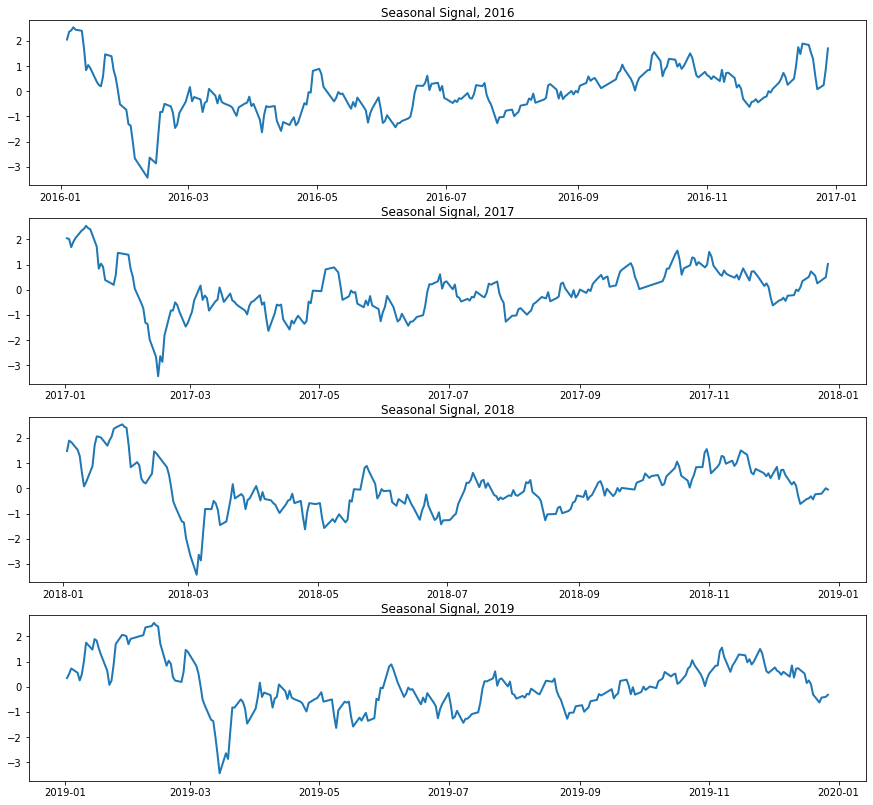

In [363]:
samsung = seasonal_decompose(df_samsung, period=250)
seasonal_2016 = samsung.seasonal[0:245]
seasonal_2017 = samsung.seasonal[246:484]
seasonal_2018 = samsung.seasonal[485:726]
seasonal_2019 = samsung.seasonal[727:971]

fig, ax = plt.subplots(4, figsize=(15,14))
ax[0].plot(seasonal_2016, lw=2.)
ax[0].set_title('Seasonal Signal, 2016', pad = 1)
ax[1].plot(seasonal_2017, lw=2.)
ax[1].set_title('Seasonal Signal, 2017', pad = 1)
ax[2].plot(seasonal_2018, lw=2.)
ax[2].set_title('Seasonal Signal, 2018', pad = 1)
ax[3].plot(seasonal_2019, lw=2.)
ax[3].set_title('Seasonal Signal, 2019', pad = 1);

- Interestingly enough we can see the almost same figures every year; price reaches its peak at the beginning of year and falls to the bottom around March. After the tumble it starts to slowly rise to the top until the end of the year, encountering several ups and downs throughout the year. 
- Given the very similar shape happening each year, we are going to add annual seasonality parameter to the function.
- The fall on 1st quarter is getting delayed every year.

Now I should add seasonality parameter to the function and run below ;
> impact = CausalImpact(df_samsung, pre_period, post_period, model_args={'niter': 5000, 'nseasons':365})

However, every time I tried to run this code Jupyter Notebook kept me hanging for a few hours and ended with an error. So I am skipping this part for now, but only leaving the code.

#### Step 3. Adding External Impact

We are moving on for another variables for the model - exogenous variables that influence Samsung Electronic's management conditions. 

Using domain knowledge, we already know that the company's business sector consists of 3 parts; semiconductor, IT/mobile communications and consumer electronics. As for semiconductor, we are going to use LG Electronics' stock price chart. LG Electronics' is not only a competitor of Samsung in home appliances, but also one of Samsung's biggest clients to supply semiconductor. Their semiconductor is used in wide range of electronics including laptop, smartphones etc. I have included Deutsche Telekom as one of exogeneous variables, Samsung's main client in Europe. Samsung has been provided smartphones and mobile equipments to Deutsche Telekom to build 5G networks. Last but not least, Best Buy is one of the biggest customers in North America when it comes to consumer electronics. The added features' linear regressions will help us understand our data better.

One thing to make sure in variable selection is to choose the variables that affect Samsung, not those who get affected by it. It means we have to mainly choose the company's clients, because when their businesses go boom, they will increase the quantity of order for Samsung which leads to stock price rocket on Samsung's side. On contrast Samsung is usually not the one that affect their business, unless there is something seriously wrong with supply of Semiconductor market. 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


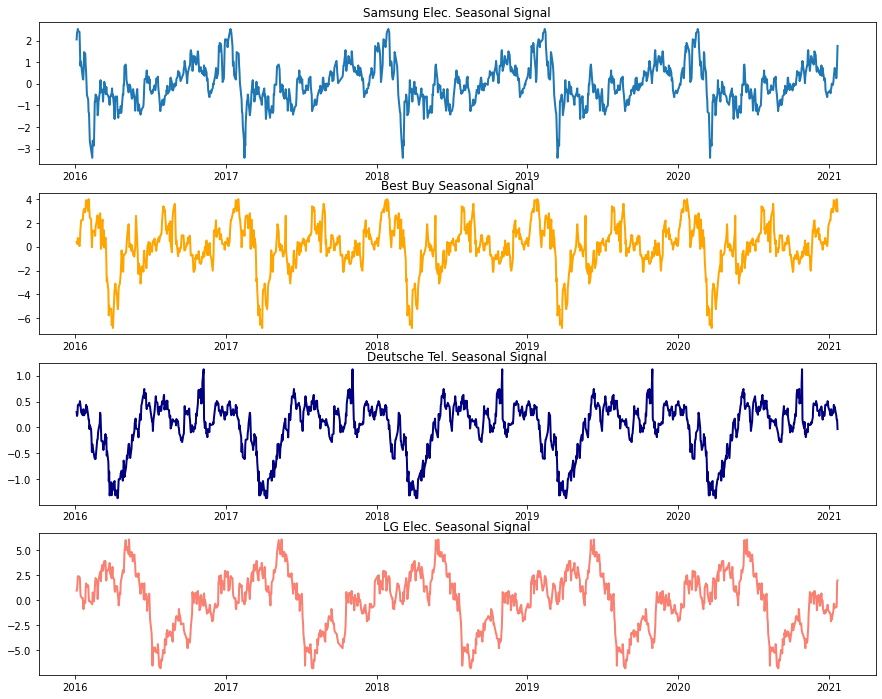

In [364]:
samsung = seasonal_decompose(df_samsung, period=250)
result_samsung = samsung.seasonal[:]

df_dt = yf.download(['DTEGY'], start = training_start, end = end_date, interval = '1d').iloc[:,4]
df_dt = df_dt*1.2
df_dt.rename('Deutsche Tel.', inplace = True)
dt = seasonal_decompose(df_dt, period=250)
result_dt = dt.seasonal[:]

df_bby = yf.download(['BBY'], start = training_start, end = end_date, interval = '1d').iloc[:,4]
df_bby.rename('Best Buy', inplace = True)
bby = seasonal_decompose(df_bby, period=250)
result_bby = bby.seasonal[:]

df_lg = yf.download(['066570.KS'], start = training_start, end = end_date, interval = '1d').iloc[:,4]
df_lg = df_lg/1100
df_lg.rename('LG Elec.', inplace = True)
lg = seasonal_decompose(df_lg, period=250)
result_lg= lg.seasonal[:]

fig, ax = plt.subplots(4, figsize=(15,12))
ax[0].plot(result_samsung, lw=2.)
ax[0].set_title('Samsung Elec. Seasonal Signal')
ax[1].plot(result_bby, lw=2., color='orange')
ax[1].set_title('Best Buy Seasonal Signal',pad = 1)
ax[2].plot(result_dt, lw=2., color = 'navy')
ax[2].set_title('Deutsche Tel. Seasonal Signal', pad = 1)
ax[3].plot(result_lg, lw=2., color = 'salmon')
ax[3].set_title('LG Elec. Seasonal Signal', pad = 1);

- All companies in the list fall to the bottom once a year, and quickly bounce back to usual level. However there are outstanding differences in each company's pattern during the year.
- LG Elec has a very similar pattern throughout the year. Its price moves to its peak at the end of the year after a huge drop. But it hits the tbottom in 2nd quarter, unlike other companies.
- Deutsche Telekom has a very interesting figure- unlike the others, its price doesn't head to peak throughout the year. Instead there are many peaks during the year and the price is generally higher in the first half in average. 
- I would say that Best Buy's feature is like a mixture of LG Electronics and Deutsche Telecom. Its price does get higher as time goes by, but at the same time there are many other smaller peaks in the middle.

In [365]:
# 2. Combining all stocks into one dataset

df_total = pd.concat([df_samsung, df_dt, df_bby, df_lg], axis = 1)
df_total.dropna(inplace = True)
df_total

,Samsung,Deutsche Tel.,Best Buy,LG Elec.
Date,,,,
2016-01-04,18.966055,17.888145,26.057716,45.649961
2016-01-05,19.013271,17.652100,26.482800,47.215099
2016-01-06,18.493869,17.621313,25.462597,47.562905
2016-01-07,18.304996,17.672625,25.700644,47.823764
2016-01-08,18.430913,17.467369,24.612429,48.606335
...,...,...,...,...
2021-01-15,79.646080,21.828001,112.596382,127.272727
2021-01-19,78.741009,21.984000,110.245689,134.545455
2021-01-20,78.922024,22.163999,110.848183,151.818182


It seems we have set all data ready. As a final step, we have to make sure that we have chosen the right stocks by conducting multicollinearity test and linear regression. If our variables all pass the tests, we will be able to run causal impact then.

In [366]:
# 3. Multicollinearity test

X = add_constant(df_total[['Best Buy', 'LG Elec.', 'Deutsche Tel.']])
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const            224.873259
Best Buy           1.688626
LG Elec.           1.743637
Deutsche Tel.      1.665663
dtype: float64

I have first added intercept as a prepararation for linear regression in the next step. We can see that all variables have small multicollinearity (less than 5. We can ignore the huge constant value, as great variable value only matters). It means no variable is considered to be linearly predicted from the others. Let's move on to linear regression to check our beta.

In [367]:
# 4. Linear regression

Y = df_total['Samsung']
X = sm.add_constant(df_total[['Best Buy', 'LG Elec.', 'Deutsche Tel.']])
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Samsung   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     2225.
Date:                Sun, 11 Jul 2021   Prob (F-statistic):               0.00
Time:                        17:35:35   Log-Likelihood:                -3404.7
No. Observations:                1197   AIC:                             6817.
Df Residuals:                    1193   BIC:                             6838.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.1483      1.806     -0.636      0.525      -4.691       2.395
Best Buy          0.3424      0.007     49.860      0.000       0.329       0.356
LG Elec.          0.1490      0.010     15.400      0.000       0.130       0.168
Deutsche Tel.     0.4635      0.111      4.170      0.000       0.245       0.682
==============================================================================
Omnibus:                       75.690   Durbin-Watson:                   0.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.679
Skew:                           0.625   Prob(JB):                     3.36e-20
Kurtosis:                       3.485   Cond. No.                     1.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It seems we have chosen the right variables that well explains Samsung's stock price change, from the high R square (0.848). Coef explains how much Samsung's price would go up when each company's price increases by $1. 
All variables add a positive impact to Samsung's stock price, given that all P-values are 0.000 which means that the increase is statistically significant. Coefficients will work as a Beta for causal impact model.

So we can define our linear regression line as follow; ```Samsung increment = -1.1483 + Best Buy increment * 0.3424 + LG increment * 0.1490 + Deutsche Tel increment * 0.4635``` (all increment in USD)

Now that we have confirmed that the we can use the variables for causal analysis, we are going to run our model. Again, do make sure that we should have run the following code with seasonality. But unfortunately I am omitting the seasonal impact due to technical limitations.

> impact = CausalImpact(df_total, pre_period = pre_period, post_period = post_period, model_args=list(niter = 5000, nseasons = 365))

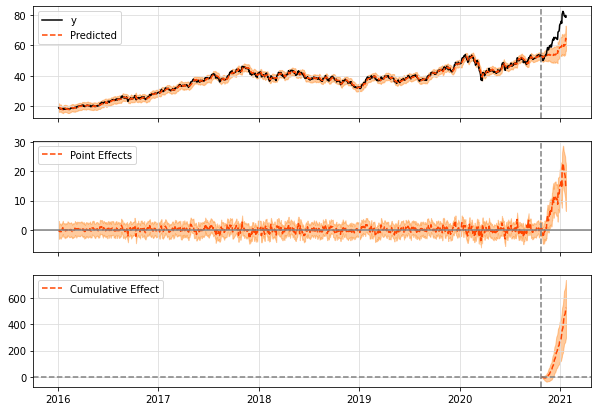

In [368]:
# 5. Run the model

pre_period = [training_start, training_end] 
post_period = [treatment_start, treatment_end] 
impact = CausalImpact(df_total, pre_period = pre_period, post_period = post_period)

impact.plot()

In [369]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    64.11              3846.83
Prediction (s.d.)         55.4 (1.97)        3323.8 (118.41)
95% CI                    [51.45, 59.19]     [3087.14, 3551.29]

Absolute effect (s.d.)    8.72 (1.97)        523.03 (118.41)
95% CI                    [4.93, 12.66]      [295.55, 759.69]

Relative effect (s.d.)    15.74% (3.56%)     15.74% (3.56%)
95% CI                    [8.89%, 22.86%]    [8.89%, 22.86%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Now the counterfactual predict looks much more realistic. It seems the covariates helped a lot in making the model more accurate. Great!

Observations:

1. We can see that Mr.Lee's death has absolutely a positive impact to Samsung's share price from tail-area probability of 0.0, which means statistically very significance.
2. The price went up approximately by USD 8.72 (15.74%)

### Conclusion

We have seen in the analysis that Samsung's share price has undoubtedly went up after the president's death. Many financial experts had forecasted that the price would remarkably jump after to the event, as the successor of the company would increase dividend which would play a role in price rise. The price has been going up even after year indeed. It is a shame that we were not able to add the seasonality factor to our model, but it seems hard to overturn the conclusion that the event clearly had an impact to the company's price.

### Reference
https://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/

https://towardsdatascience.com/implementing-causal-impact-on-top-of-tensorflow-probability-c837ea18b126